<h2>Area-Averaged Fields</h2>

This example demonstrates how to take 3-D WRF-ARW output, compute the area average over a specified lat/lon range, and create a line plot (x-axis: magnitude, y-axis: logarithmic pressure) of the resulting quantity.

The example below plots the area-averaged horizontal wind speed (between 1000-100 hPa) over a small domain centered on Hurricane Matthew valid at two separate times, 2100 UTC 7 October 2016 and 0000 UTC 8 October 2016, using data obtained from the Assignment 1 tutorial case.

More information on how to use wrf-python is available at https://wrf-python.readthedocs.io/en/main/basic_usage.html.

<hr>

We start by importing the needed modules. These are drawn from four packages - netCDF4, matplotlib, numpy, and wrf (short for wrf-python). We do not need to load cartopy because there is no mapping involved. Note that wrf-python treats data as xarrays, which makes xarray functions (such as the sel function we use to subset data) available to us without loading xarray ourselves.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)
from netCDF4 import Dataset
from wrf import to_np, getvar, ll_to_xy

Open the desired wrfout files (each of which in this instance contain data for only a single output time).

In [2]:
ncfile1 = Dataset("wrfout_d01_2016-10-07_21:00:00")
ncfile2 = Dataset("wrfout_d01_2016-10-08_00:00:00")

Extract the 3-D model pressure and wind speed from each file. The first is in hPa by default whereas the latter is specified in kt. All are wrf-python derived variables.

The uvmet_wspd_dir function returns both speed and direction relative to the Earth. The wind speed is the 0th element of the first dimension. The second dimension is the 3-D data themselves.

In [3]:
p1 = getvar(ncfile1, "pressure")
p2 = getvar(ncfile2, "pressure")
wspd1 = getvar(ncfile1, "uvmet_wspd_wdir", units="kt")[0,:]
wspd2 = getvar(ncfile2, "uvmet_wspd_wdir", units="kt")[0,:]

Specify the latitude and longitude ranges over which to compute the area average, then use the wrf-python ll_to_xy helper function to convert these to x/y points. We call this helper function because the model variables have dimensions south_north and west_east, which refer to x/y points rather than to lat/lon location, and these variables are what we will later use to subset the data for the area average.

The pair lat1,lon1 refers to the southwestern corner of the domain, whereas the pair lat2,lon2 refers to the northeastern corner of the domain. The resulting x/y values provide us with the bounds for the area average to come. We only need to do this using data from one file because the domains in each file are identical.

In [4]:
lat1 = 26.0
lat2 = 34.0
lon1 = -87.0
lon2 = -76.0

x1, y1 = to_np(ll_to_xy(ncfile1, lat1, lon1))
x2, y2 = to_np(ll_to_xy(ncfile1, lat2, lon2))

Next, we subset the data from the full domain to just that associated with our area average. We use the xarray helper function sel() to do so. Note how we save the subset data to a new variable; this allows us to continue to work with the full dataset without reloading it if we wish to do so. We pass the subsetting bounds to each dimension (south_north and west_east) as slices, which are sequences of numbers from the first entry to the second entry.

In [5]:
p_sub1 = p1.sel(south_north=slice(y1,y2), west_east=slice(x1,x2))
p_sub2 = p2.sel(south_north=slice(y1,y2), west_east=slice(x1,x2))
wspd_sub1 = wspd1.sel(south_north=slice(y1,y2), west_east=slice(x1,x2))
wspd_sub2 = wspd2.sel(south_north=slice(y1,y2), west_east=slice(x1,x2))

Printing the resulting p_sub1 variable displays its data and associated dimensions. Note that south_north is now 33, west_east is now 39, and the values of the coordinates XLONG and XLAT range from 26-34°N and 87-76°W as specified.

In [6]:
print(p_sub1)

<xarray.DataArray 'pressure' (bottom_top: 44, south_north: 33, west_east: 39)>
array([[[1007.38116 , 1007.1981  , 1006.9569  , ..., 1008.7651  ,
         1009.0495  , 1009.2923  ],
        [1007.42755 , 1007.2286  , 1006.98505 , ..., 1008.65875 ,
         1008.98895 , 1009.2417  ],
        [1007.4106  , 1007.2029  , 1006.9538  , ..., 1008.6405  ,
         1008.94934 , 1009.20746 ],
        ...,
        [ 990.23676 ,  989.9155  ,  989.5922  , ..., 1011.7659  ,
         1012.1254  , 1012.4788  ],
        [ 990.1586  ,  986.83563 ,  989.1529  , ..., 1012.0551  ,
         1012.38763 , 1012.6801  ],
        [ 991.6451  ,  985.33386 ,  985.30566 , ..., 1012.37836 ,
         1012.6519  , 1012.8895  ]],

       [[1001.0781  , 1000.9083  , 1000.7012  , ..., 1002.4446  ,
         1002.72516 , 1002.9678  ],
        [1001.11975 , 1000.8888  , 1000.7079  , ..., 1002.36176 ,
         1002.6685  , 1002.8972  ],
        [1001.1164  , 1000.90497 , 1000.66144 , ..., 1002.31323 ,
         1002.629   , 10

The area-average for each variable can be obtained using xarray's mean attribute function, specifying both dimensions' names when doing so to ensure the mean is taken over both spatial dimensions. The resulting variable has a single varying dimension, bottom_top, representing the model's vertical dimension.

In [7]:
p_mean1 = p_sub1.mean(dim=['south_north', 'west_east'])
p_mean2 = p_sub2.mean(dim=['south_north', 'west_east'])
wspd_mean1 = wspd_sub1.mean(dim=['south_north', 'west_east'])
wspd_mean2 = wspd_sub2.mean(dim=['south_north', 'west_east'])

The remainder of the plot-generation code is contained in a single code block below. This is due to a Python quirk; a figure is generated before we add any data to it if we try to break the code up into separate code blocks. Please see the comment blocks below to interpret the code.

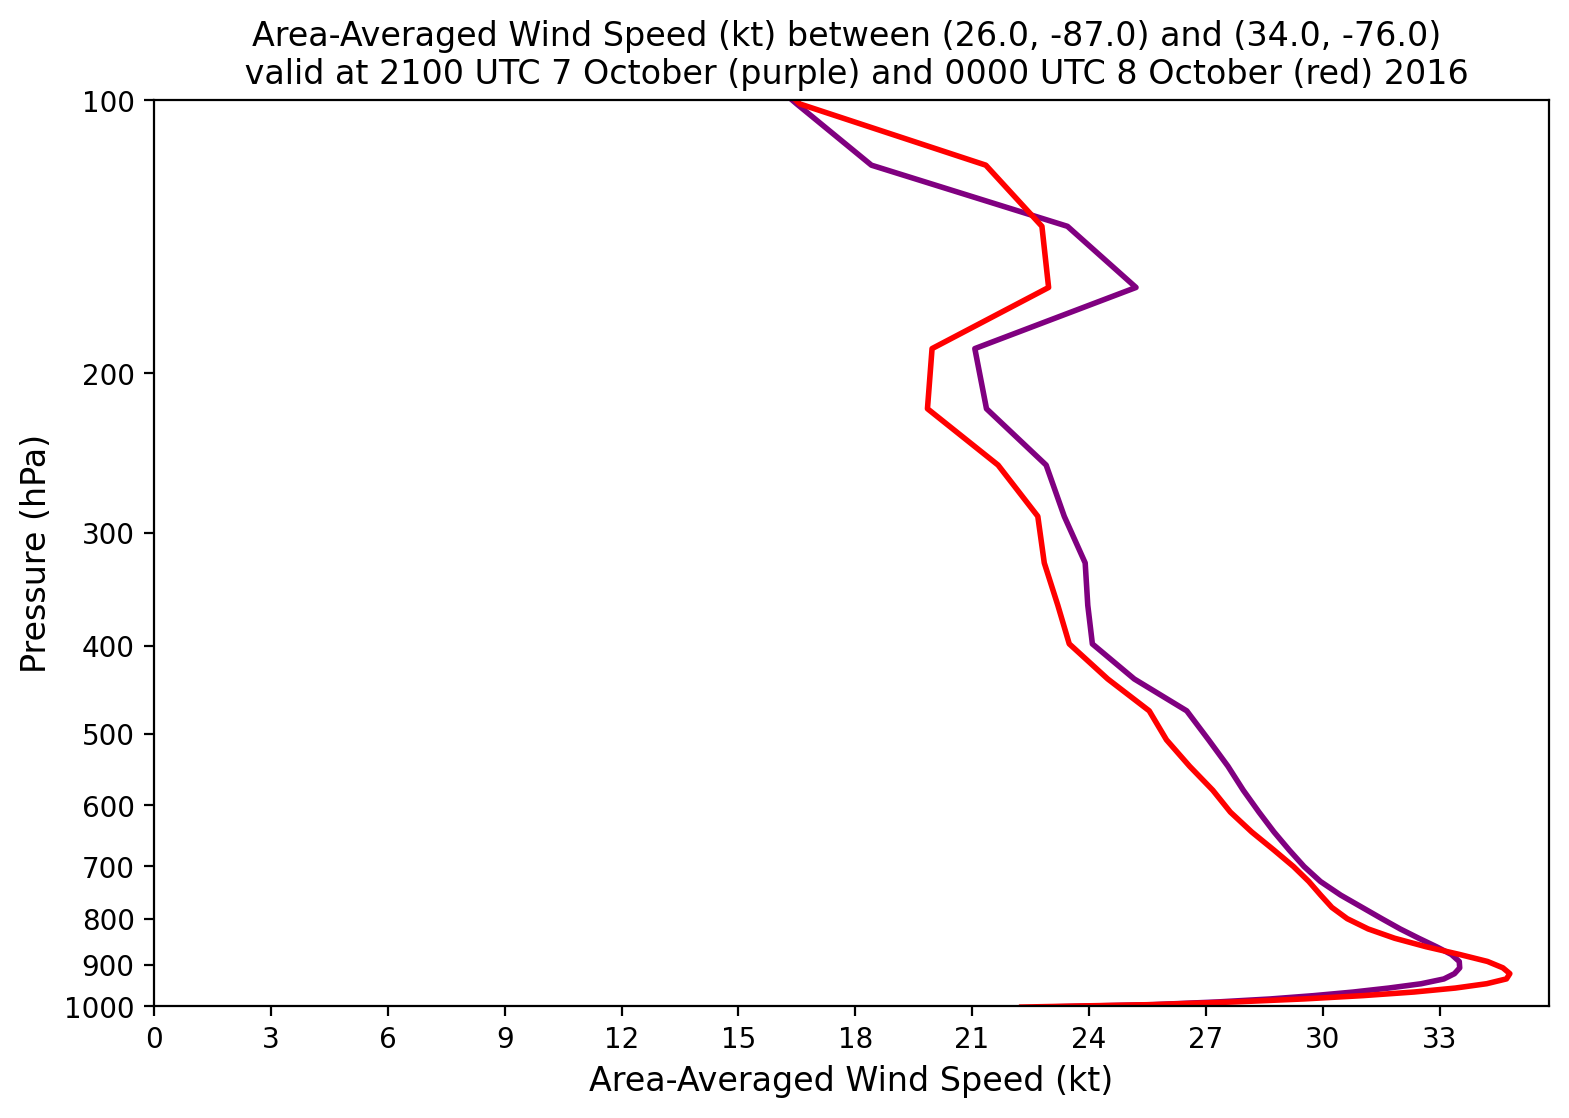

In [8]:
# Create the figure instance (9" wide by 6" tall,
# 200 dots per inch), then establish the figure's axes.
fig = plt.figure(figsize=(9,6), dpi=200.)
ax = plt.axes()

# We plot the data as the area-averaged field (wspd_mean)
# versus pressure (p_mean) with plt.plot:
plt.plot(wspd_mean1, p_mean1, color='purple', marker=None, 
         linestyle='solid', linewidth=2)
plt.plot(wspd_mean2, p_mean2, color='red', marker=None, 
         linestyle='solid', linewidth=2)

# This set of code structures our x-axis. We first
# set the lower bound on the x-axis to zero (the lowest-
# possible wind speed). We do not change the upper bound
# because we want this to be determined by the data. Then,
# we get the x-axis' start and end values and use them to
# set the x-axis tick marks to be every 3 kt (for illustrative
# purposes only).
ax.set_xbound(lower=0,upper=None)
xstart, xend = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(xstart, xend, 3.0))

# This set of code structures our y-axis ticks and their labels.
# We first set the y-axis to be logarithmic rather than linear.
# Next, we set how the logarithmic axis labels should be structured,
# using scalars rather than powers of 10. Once we have
# done that, we define ten y-axis ticks from 100 to 1000 hPa.
# Finally, we set the y-axis limits - in this case, 1000-100 hPa.
ax.set_yscale('symlog')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_yticks(np.linspace(100, 1000, 10))
ax.set_ylim(1000., 100.)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Area-Averaged Wind Speed (kt)", fontsize=12)
ax.set_ylabel("Pressure (hPa)", fontsize=12)

# Title the plot and then display it. Note the \n
# operate to split the title over two lines.
plt.title("Area-Averaged Wind Speed (kt) between (" + str(lat1) + ", " + str(lon1) + ") and (" + str(lat2) + ", " + str(lon2) + ") \n valid at 2100 UTC 7 October (purple) and 0000 UTC 8 October (red) 2016")
plt.show()